In [1]:
import numpy as np
import random
from DeepESN import DeepESN
from utils import MSE, load_chest_full, select_indexes
from sklearn.model_selection import ParameterGrid
import copy
import csv
import time

class Struct(object): pass

np.random.seed(9)
random.seed(9)

In [2]:
# trains the ESN by initializing it, computing all states, and then performing SVD for Wout
def train(Nr, Nl, reg, transient, rhos, lis, iss, con):
    configs = Struct()
 
    configs.rhos = rhos
    configs.lis = lis
    configs.iss = iss

    configs.IPconf = Struct()
    configs.IPconf.DeepIP = 0 # deactivate pre-train

    configs.reservoirConf = Struct()
    configs.reservoirConf.connectivity = con 

    configs.readout = Struct()
    configs.readout.trainMethod = 'SVD' # train with singular value decomposition (more accurate)
    
    deepESN = DeepESN(Nu, Nr, Nl, configs)
    states = deepESN.computeState(dataset.inputs, deepESN.IPconf.DeepIP)
        
    train_states = select_indexes(states, list(TR_indexes) + list(VL_indexes), transient)
    train_targets = select_indexes(dataset.targets, list(TR_indexes) + list(VL_indexes), transient)
    test_states = select_indexes(states, TS_indexes)
    test_targets = select_indexes(dataset.targets, TS_indexes)
    
    deepESN.trainReadout(train_states, train_targets, reg)

    return score(deepESN, train_states, test_states, test_targets), test_targets[0].tolist()

In [3]:
# computes self fed and signal fed output data
def score(deepESN, train_states, test_states, test_targets):
    #compute error SIGNAL FED
    test_states_std = copy.deepcopy(test_states)
    test_outputs_std = deepESN.computeOutput(test_states_std)
    test_error_std = MSE(test_outputs_std, test_targets)

    #compute error SELF FED
    test_outputs = []
    state = [train_states[0][:,-1:]] #set last training state as initial state
    output = [np.array(deepESN.computeOutput(state))] #set last training output as initial output
    for t in range(len(test_states[0][0])):
        state = deepESN.computeState(inputs=output, DeepIP=0, initialStates=state[0])
        output = deepESN.computeOutput(state)
        test_outputs.append(output[0][0])
        output = [np.array(output)]

    test_error = MSE(np.array(test_outputs), np.array(test_targets))
    return test_error, test_outputs, test_error_std, test_outputs_std[0].tolist()

In [4]:
# set parameters

args = {
    "Nr": 200,            # number of recurrent units
    "Nl": 5,              # number of recurrent layers
    "reg": 10.0,          # regularization of svd
    "transient": 1000,    # washout
    "rhos": 1.0,          # set spectral radius for all recurrent layers
    "lis": 0.1,           # set leaky rate for all recurrent layers
    "iss": 1.0,           # set input scale for all recurrent layers
    "con": 0.2,           # connectivity of recurrent matrix
    ".sampling": 1        # set step size for sampling, 1 is no sampling. be careful not to make dataset too small
}


start = time.time()
# load dataset
dataset, Nu, TR_indexes, VL_indexes, TS_indexes = load_chest_full('datasets')
# train model and compute outputs
output, test_targets = train(Nr=args['Nr'], Nl=args['Nl'], reg=args['reg'], transient=args['transient'], rhos=args['rhos'], lis=args['lis'], iss=args['iss'], con=args['con'])


print("time taken: " + str(time.time()-start))

input length =  79999
.7 =  55999
.8 =  63999
-1 =  79998
Done loading data
time taken: 59.49342608451843


In [6]:
print(output[0], output[2])

10.291619164981995 0.00026499756811204265


In [28]:
# csv export of output data to be able to do analysis independent of training
keys = []
for key in search_space_short[0].keys():
    keys.append(key)
keys.append("MSE")
keys.append("outputs")
keys.append("MSE_std")
keys.append("outputs_std")

header = keys

with open('results_MG.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(header)

    for i in range(len(search_space_short)):
        vals = []
        for val in search_space_short[i].values():
            vals.append(val)
        for j in range(len(results[0])):
            vals.append(results[i][j])
        write.writerow(vals)

        
with open('targets_MG.csv', 'w') as f:
    write = csv.writer(f)
    header = ["sampling rate", "test_targets"]
    write.writerow(header)
    
    for row in targets:
        write.writerow(row)


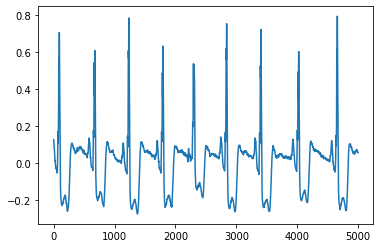

In [6]:
import matplotlib.pyplot as plt
plt.plot(test_targets[0][:5000])

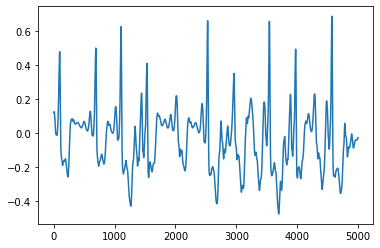

In [7]:
plt.plot(output[1][:5000])